# Adversarial starts below

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np 
import time 
import scipy
from keras import Sequential
from keras import Model
from google.colab.patches import cv2_imshow

num_classes = 1000
input_shape = (28, 28, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
X_train = np.stack([x_train, x_train, x_train], axis=-1)
X_test = np.stack([x_test, x_test, x_test], axis=-1)
Y_train = keras.utils.to_categorical(y_train,1000)
Y_test = keras.utils.to_categorical(y_test,1000)

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
input_mask = np.pad(np.zeros([1, 28, 28, 3]),
                            [[0,0], [98, 98], [98, 98], [0,0]],
                            'constant', constant_values = 1)
input_mask.shape

(1, 224, 224, 3)

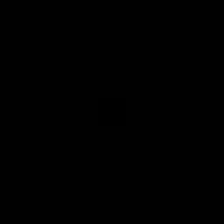

In [3]:
cv2_imshow(input_mask[0])

In [4]:
import keras.backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)
from keras import initializers,regularizers
from keras.optimizers import *
from keras.callbacks import *

M = np.ones((224,224,3)).astype('float32')
M[98:126,98:126,:] = 0

class AdvLayer(Layer):
    def __init__(self, W_regularizer=0.05, **kwargs):
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.l2(W_regularizer)
        super(AdvLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        assert len(input_shape) == 4
        self.W = self.add_weight(name='kernel', 
                                      shape=(224,224,3),
                                      initializer=self.init, regularizer=self.W_regularizer,
                                      trainable=True)
        super(AdvLayer, self).build(input_shape)
    def call(self, x):
        prog = K.tanh(self.W*M)
        out = x + prog
        return out
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2],input_shape[3])

In [5]:
basemodel = tf.keras.applications.MobileNet(weights="imagenet")
x = Input(shape=input_shape)
x_aug = ZeroPadding2D(padding=((98,98),(98,98)))(x)
out = AdvLayer()(x_aug)
probs = basemodel(out)
model = Model(inputs=x,outputs=probs)
model.layers[-1].trainable = False
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 adv_layer (AdvLayer)        (None, 224, 224, 3)       150528    
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
Total params: 4,404,392
Trainable params: 150,528
Non-trainable params: 4,253,864
______________________________________________

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("advweights.h5",save_freq='epoch', save_best_only = True, monitor='loss',
                            save_weights_only=True, mode='min', verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, min_lr=0.000001, mode='auto')
stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode= 'min')
history = model.fit(X_train,Y_train,epochs = 100,batch_size=16, validation_data = (X_test,Y_test), verbose=1, callbacks=[checkpoint,reduce_lr,stopping])

Epoch 1/100
3750/3750 [==============================] - 488s 122ms/step - loss: 1.4114 - accuracy: 0.7561 - val_loss: 1.2219 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 2/100
3750/3750 [==============================] - 475s 127ms/step - loss: 1.2050 - accuracy: 0.8138 - val_loss: 1.1856 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 3/100
3750/3750 [==============================] - 457s 122ms/step - loss: 1.1700 - accuracy: 0.8212 - val_loss: 1.0138 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 4/100
3750/3750 [==============================] - 458s 122ms/step - loss: 1.1311 - accuracy: 0.8285 - val_loss: 1.0461 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 5/100
3750/3750 [==============================] - 458s 122ms/step - loss: 1.1346 - accuracy: 0.8283 - val_loss: 1.0166 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 6/100
3750/3750 [==============================] - 476s 127ms/step - loss: 1.1134 - accuracy: 0.8346 - val_loss: 1.0425 - val_accuracy: 0.8518 - lr: 0.0010
Epoch 7/100
3750/3750 [=====

In [ ]:
model.add_weight('/content/drive/MyDrive/cs663 weights/advweights_MobileNet.h5')

<tf.Variable '/content/drive/MyDrive/cs663 weights/advweights_MobileNet.h5:0' shape=() dtype=float32, numpy=-1.103058>

In [ ]:
from keras.models import Model
import tensorflow as tf

layer_name = 'adv_layer_3'
intermediate_layer_model = Model(inputs=model.get_layer('input_8').output,
                                 outputs=model.get_layer(layer_name).output)
intermediate_layer_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 224, 224, 3)      0         
 ng2D)                                                           
                                                                 
 adv_layer_3 (AdvLayer)      (None, 224, 224, 3)       150528    
                                                                 
Total params: 150,528
Trainable params: 150,528
Non-trainable params: 0
_________________________________________________________________


In [ ]:
intermediate_output = intermediate_layer_model.predict(tf.expand_dims(X_test[0],axis=0))

In [ ]:
from matplotlib.pyplot import imshow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


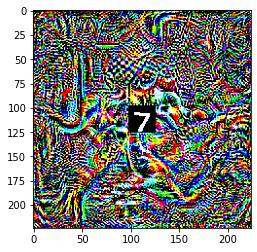

In [ ]:
img = tf.math.atanh(intermediate_output[0])
imshow(img*255)

In [ ]:
out = model.predict(tf.expand_dims(X_test[0],axis=0))
print(np.argmax(out[0]))
out[0][np.argmax(out[0])]

7


0.97561806